## Predict price at next period with LSTM and Keras as a Classification


In [3]:
import sys
import time
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY

import mysql.connector
from mysql.connector import errorcode

import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
 
#from sklearn import metrics
#from sklearn.preprocessing import MinMaxScaler, normalize, scale

print(tf.__version__)
print(sys.version)

# https://mapr.com/blog/deep-learning-tensorflow/


1.5.0
3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [4]:
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam, adagrad
from keras import backend as K

from ittutils import ittconnection, get_resampled, get_raw_price, get_raw_volume, classification_dataset_from_ts

### Get price and volume timeseries from Staging DB 


Shape of BTC(103837, 2)


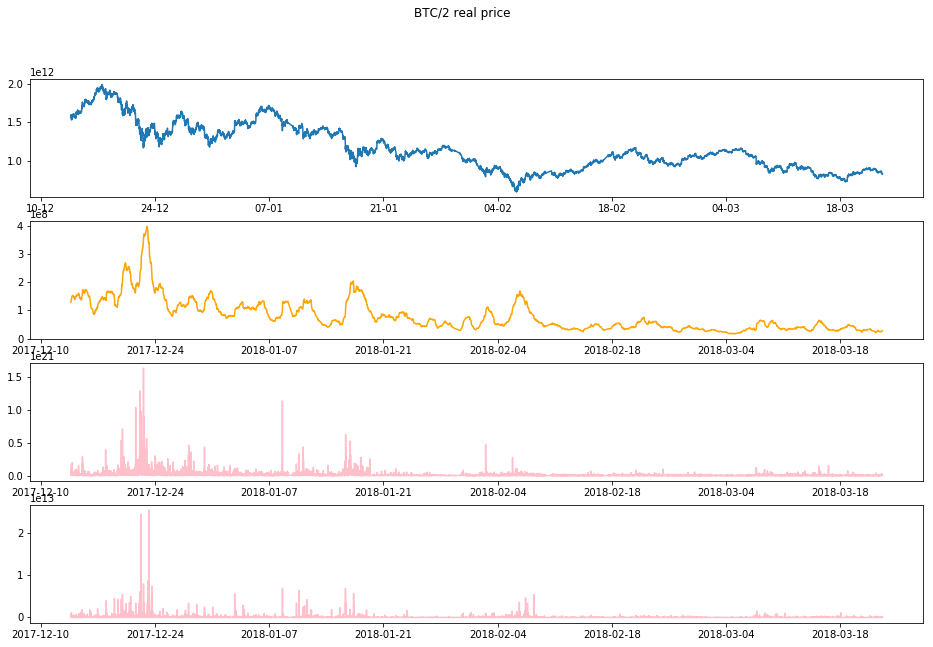

Shape of ETH(103836, 2)


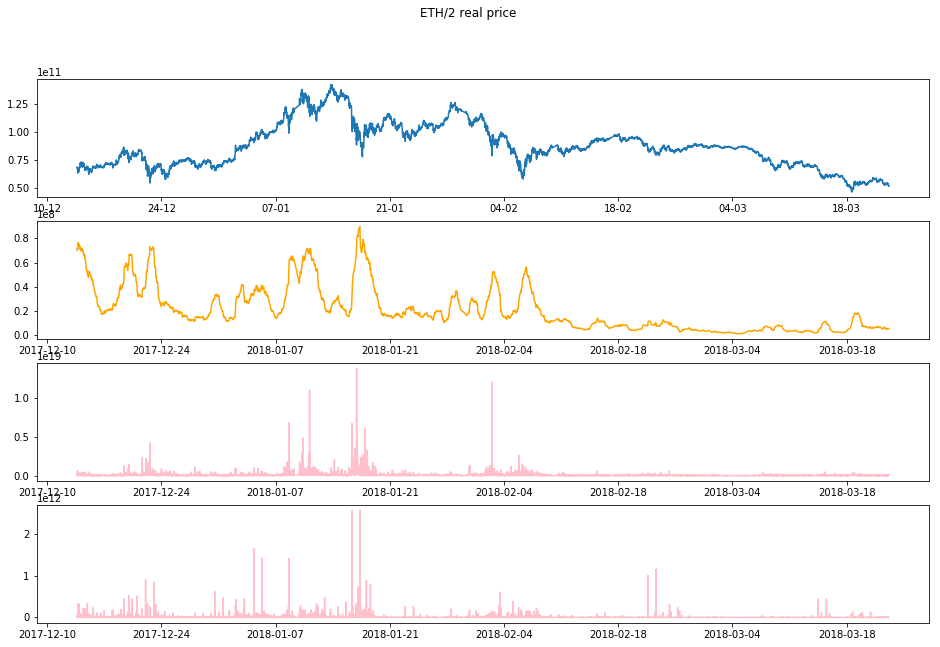

Shape of ETH(178909, 2)


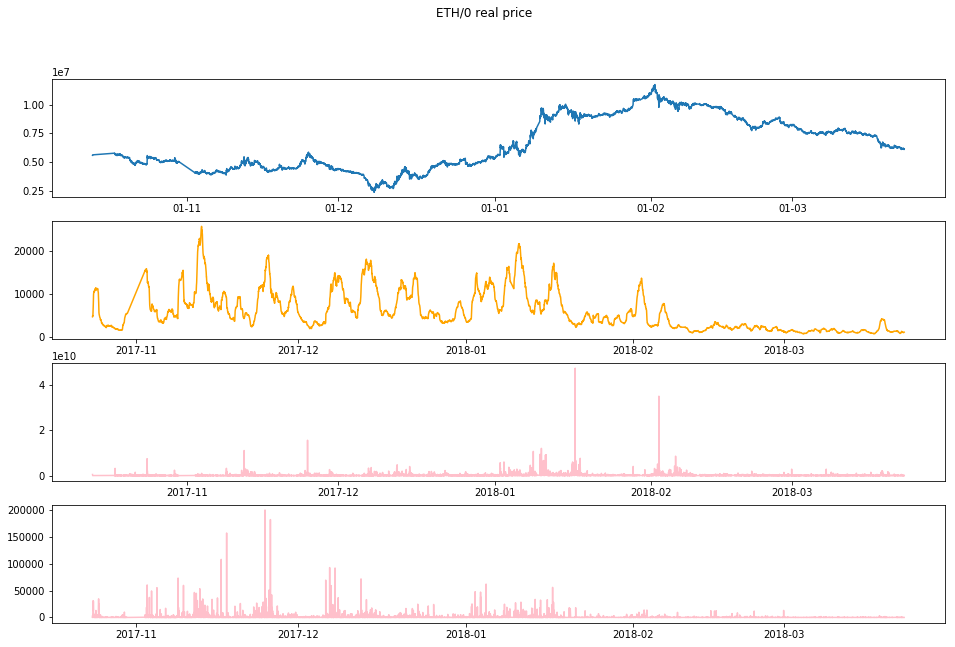

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Shape of ETC(178908, 2)


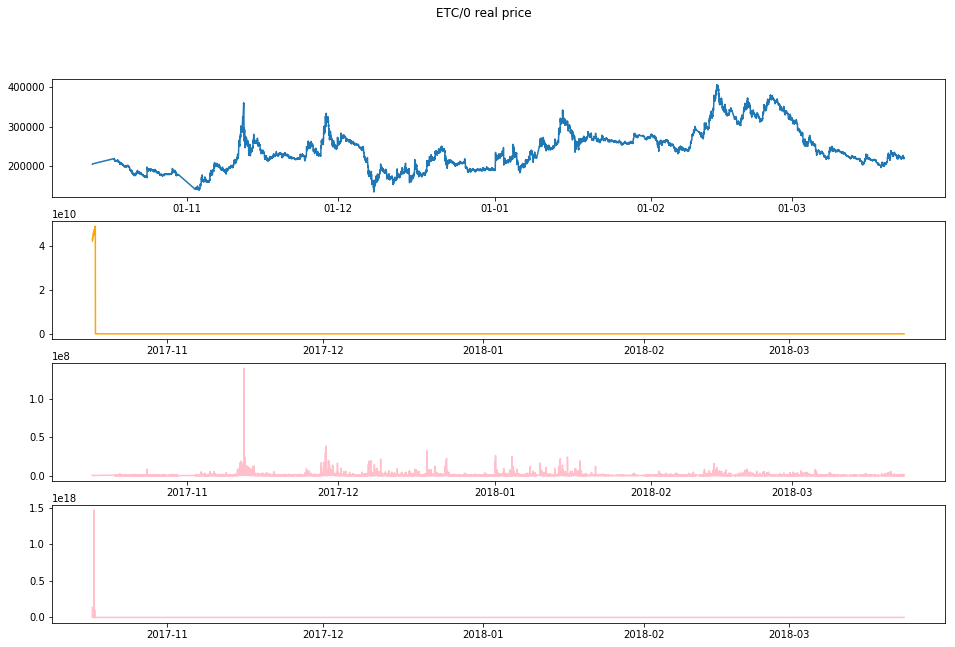

Shape of OMG(178910, 2)


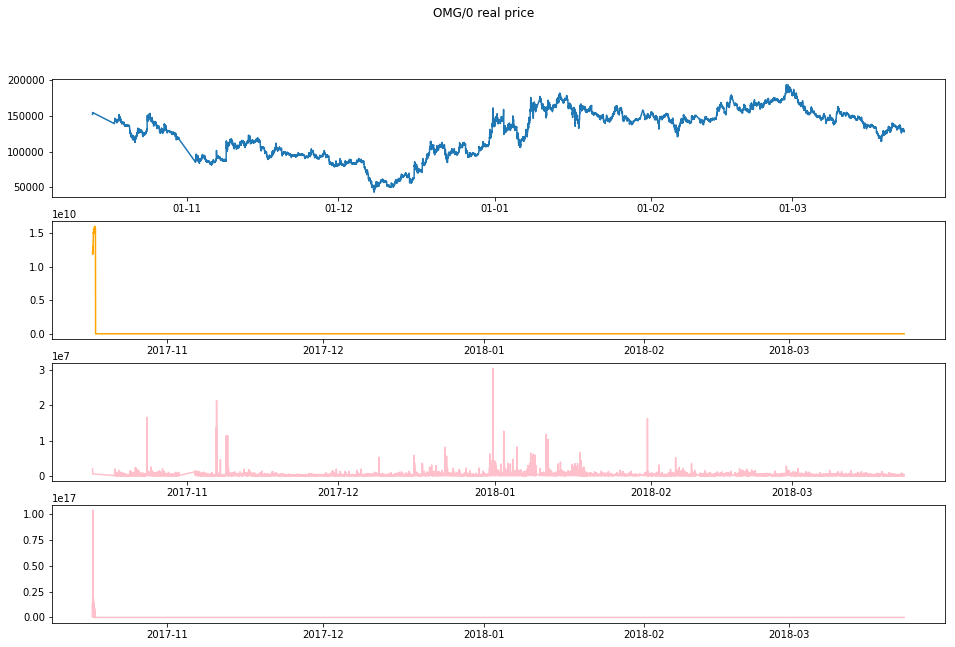

Shape of XRP(178909, 2)


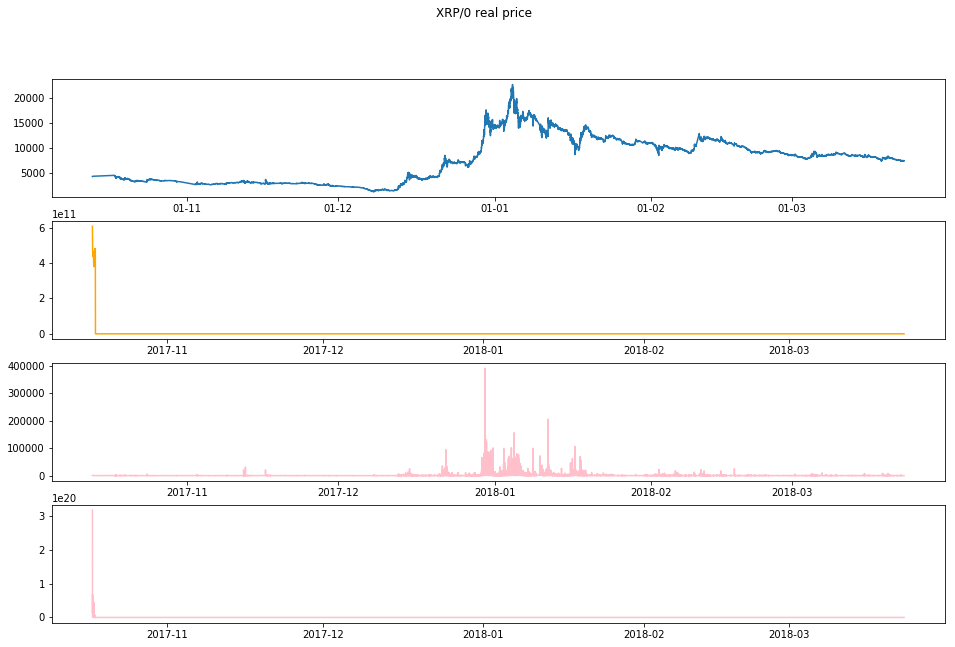

Shape of XMR(178909, 2)


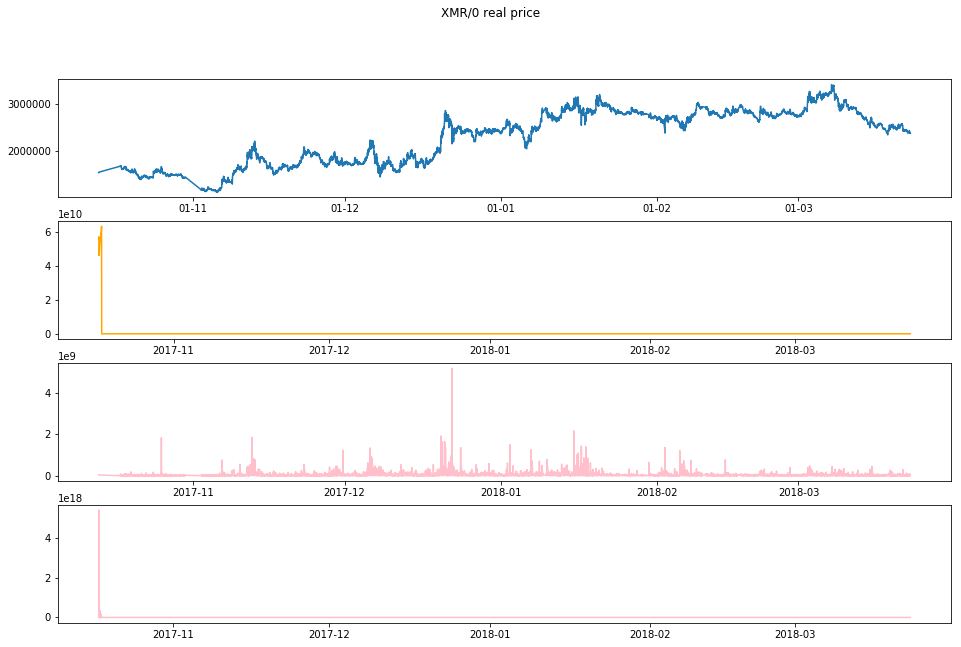

Shape of LTC(178906, 2)


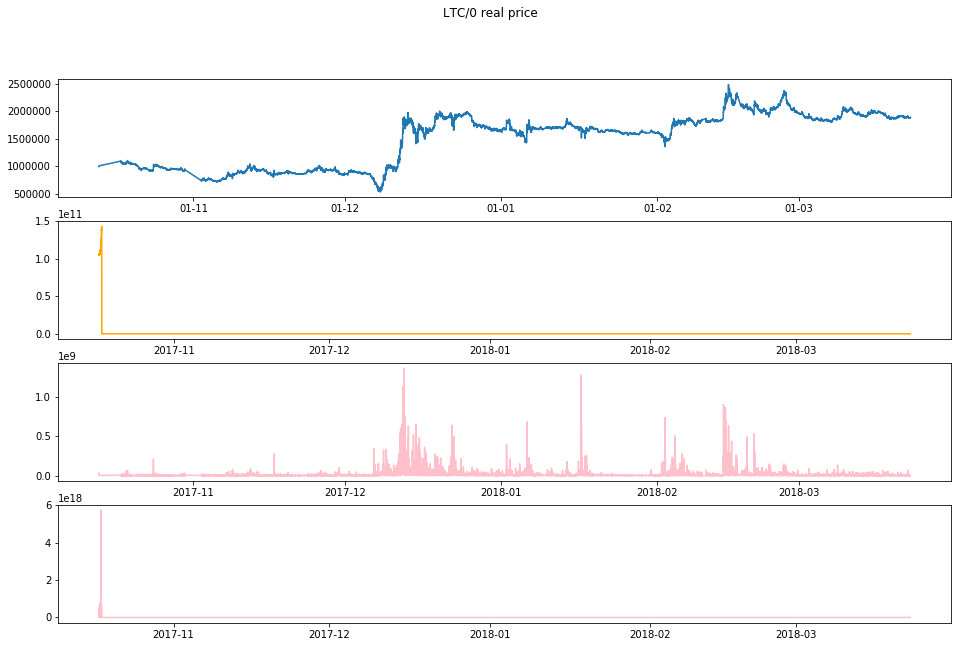

(147319, 200, 4)
(147319, 3)


In [5]:
db_connection = ittconnection('prodcopy')›

COINS_LIST = [('BTC',2), ('ETH',2), ('ETH',0), ("ETC",0), ('OMG',0), ('XRP',0), ('XMR',0), ('LTC',0)]

X_train = []
Y_train = []

for transaction_coin, counter_coin in COINS_LIST:
    raw_price_ts = get_raw_price(db_connection, transaction_coin, counter_coin)
    raw_volume_ts = get_raw_volume(db_connection, transaction_coin, counter_coin)

    raw_data_frame = pd.merge(raw_price_ts, raw_volume_ts, how='left', left_index=True, right_index=True)
    print('Shape of ' + transaction_coin + str(raw_data_frame.shape))
    
    raw_data_frame[pd.isnull(raw_data_frame)] = None
    
    # resample (for smoothing) and normalize (for learning)
    res_period = '10min'
    data_ts = raw_data_frame.resample(rule=res_period).mean()
    data_ts['price_var'] = raw_data_frame['price'].resample(rule=res_period).var()
    data_ts['volume_var'] = raw_data_frame['volume'].resample(rule=res_period).var()
    
    data_ts = data_ts.interpolate() 
    
    # visually inspect the price and volume
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(nrows=4, ncols=1, figsize=(16,10))
    fig.suptitle("%s/%d real price" % (transaction_coin, counter_coin))
    ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
    ax1.plot(data_ts['price'])
    ax2.plot(data_ts['volume'], color='orange')
    ax3.plot(data_ts['price_var'], color='pink')
    ax4.plot(data_ts['volume_var'], color='pink')
    plt.show()
    
    win_size = 200 # do prediction based on history
    future = 90    # predict a price return in future timepoints (6h?)
    delta = 0.02  # consider UP if last price has been changed by more then delta persents
    
    if transaction_coin == 'BTC':
        X_test, Y_test, y_tst_price = classification_dataset_from_ts(data_df=data_ts, win_size=win_size, stride=1, future=future, delta=delta)
    else:
        X_train_one, Y_train_one, y_tr_price = classification_dataset_from_ts(data_df=data_ts, win_size=win_size, stride=1, future=future, delta=delta)
        
        if X_train == []:
            X_train = X_train_one
            Y_train = Y_train_one
        else:
            X_train = np.concatenate((X_train, X_train_one),axis=0) 
            Y_train = np.concatenate((Y_train, Y_train_one),axis=0)
            
# delete all examples with NaN inside
idx2delete = []
for n in range(X_train.shape[0]-1):
    if np.isnan(X_train[n,:,:]).any():
        idx2delete.append(n)
        
X_train = np.delete(X_train, (idx2delete), axis=0)
Y_train = np.delete(Y_train, (idx2delete), axis=0)
    
print(X_train.shape)
print(Y_train.shape)

In [6]:
for n in range(X_train.shape[0]):
    if np.isnan(X_train[n,:,:]).any():
        print(n)

In [7]:
#X_train[0,:,0]

# CLASSIFICATION

### Normalize dataset

In [8]:
#plt.plot(X_train[37523,:,0])


In [9]:
'''
for example in range(X_train.shape[0]):
    X_train[example,:,0] = scale(X_train[example,:,0])
    X_train[example,:,1] = scale(X_train[example,:,1])
    X_train[example,:,2] = scale(X_train[example,:,2])
    X_train[example,:,3] = scale(X_train[example,:,3])

for example in range(X_test.shape[0]):
    X_test[example,:,0] = scale(X_test[example,:,0])
    X_test[example,:,1] = scale(X_test[example,:,1])
    X_test[example,:,2] = scale(X_test[example,:,2])
    X_test[example,:,3] = scale(X_test[example,:,3])
'''
# ((price_ts - price_ts.mean()) / (price_ts.max() - price_ts.min()) )
# we normalize to the last element in the exaple set to make algorithm to catch patter more aeasily

for example in range(X_train.shape[0]):
    X_train[example,:,0] = (X_train[example,:,0] - X_train[example,-1,0]) / (np.max(X_train[example,:,0]) - np.min(X_train[example,:,0]))
    X_train[example,:,1] = (X_train[example,:,1] - X_train[example,-1,1]) / (np.max(X_train[example,:,1]) - np.min(X_train[example,:,1]))
    X_train[example,:,2] = (X_train[example,:,2] - X_train[example,-1,2]) / (np.max(X_train[example,:,2]) - np.min(X_train[example,:,2]))
    X_train[example,:,3] = (X_train[example,:,3] - X_train[example,-1,3]) / (np.max(X_train[example,:,3]) - np.min(X_train[example,:,3]))


for example in range(X_test.shape[0]):
    X_test[example,:,0] = (X_test[example,:,0] - X_test[example,-1,0]) / (np.max(X_test[example,:,0]) - np.min(X_test[example,:,0]))
    X_test[example,:,1] = (X_test[example,:,1] - X_test[example,-1,1]) / (np.max(X_test[example,:,1]) - np.min(X_test[example,:,1]))
    X_test[example,:,2] = (X_test[example,:,2] - X_test[example,-1,2]) / (np.max(X_test[example,:,2]) - np.min(X_test[example,:,2]))
    X_test[example,:,3] = (X_test[example,:,3] - X_test[example,-1,3]) / (np.max(X_test[example,:,3]) - np.min(X_test[example,:,3]))



In [10]:
#plt.plot(X_train[3000,:,1])

### Color the price plot according to label

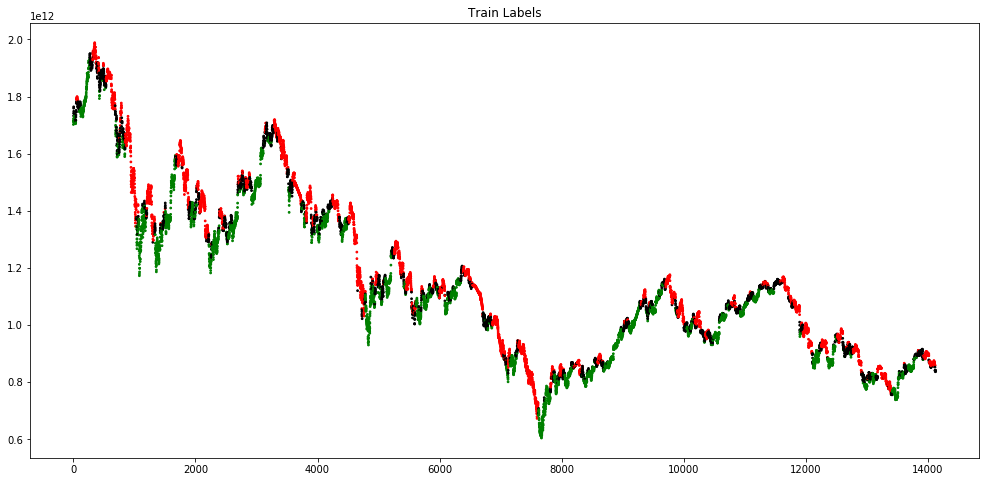

In [11]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(17,8))

ax1.set_title("Train Labels")    
color_label = []
for p in Y_test:  
    if p[1] == 1:
        color = 'green'
    elif p[2] == 1:
        color = 'red' 
    else:
        color = 'black'
    color_label.append(color)

ax1.scatter(range(y_tst_price.shape[0]),  y_tst_price, c=color_label, s=3)

plt.show()

In [12]:

n_time_features = X_train.shape[1]
classes = Y_train.shape[1]
m_test = X_test.shape[0]
m_train = X_train.shape[0]


In [13]:
X_train = X_train.astype(dtype=np.float32)
X_test = X_test.astype(dtype=np.float32)


print(X_train.shape)
print(Y_train.shape)
#print("Y train first  = ")
#print( str(Y_train[0:3,]))

print(X_test.shape)
print(Y_test.shape)

print(" m_train %d, m_test %d, n_features %d, classes %d" % (m_train, m_test, n_time_features, classes ))
  

(147319, 200, 4)
(147319, 3)
(14126, 200, 4)
(14126, 3)
 m_train 147319, m_test 14126, n_features 200, classes 3


# KERAS
The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions 

(N, W, F) where
- N is the number of training sequences, 
- W is the sequence length and 
- F is the number of features of each sequence

network structure of [1, 50, 100, 1] where 
- 1 input layer (consisting of a sequence of size 50) which feeds into an LSTM layer with 50 neurons, 
- that in turn feeds into another LSTM layer with 100 neurons 
- which then feeds into a fully connected normal layer of 1 neuron with a linear activation function which will be used to give the prediction of the next time step.

<img src="images/rnn.jpeg" style="width:600;height:400px;">

In [14]:
#layers = [1, win_size, 100, 1]


data_dim = 4
timesteps = win_size
num_classes = 3

def build_model():
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()

    model.add(
        LSTM(
            90, 
            return_sequences=True,
            input_shape=(timesteps, data_dim),
            dropout=0.15
        )
    )  # returns a sequence of vectors of dimension 32
    
    model.add(LSTM(64, return_sequences=True, dropout=0.15))  
    
    model.add(LSTM(32, return_sequences=True, dropout=0.15))
    
    model.add(LSTM(16, dropout=0.15))  # return a single vector of dimension 32
    
    model.add(Dense(num_classes, activation='softmax'))


    optimizer = adagrad(lr=0.0005)
    
    start = time.time()
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    #predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [16]:
# epoch = one forward pass and one backward pass of all the training examples

# batch size = the number of training examples in one forward/backward pass. 
#              The higher the batch size, the more memory space you'll need.

# if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

epochs  = 40  # 100

model = build_model()

history = model.fit(
    X_train,
    Y_train,
    batch_size=7000,
    epochs=epochs,
    validation_split=0.15)





> Compilation Time :  0.01717543601989746
Train on 125221 samples, validate on 22098 samples
Epoch 1/40
125221/125221 [==============================] - 109s 871us/step - loss: 1.0957 - acc: 0.3816 - val_loss: 1.0817 - val_acc: 0.5111
Epoch 2/40
125221/125221 [==============================] - 107s 857us/step - loss: 1.0902 - acc: 0.3870 - val_loss: 1.0627 - val_acc: 0.5130
Epoch 3/40
125221/125221 [==============================] - 107s 856us/step - loss: 1.0873 - acc: 0.3875 - val_loss: 1.0557 - val_acc: 0.5119
Epoch 4/40
125221/125221 [==============================] - 107s 856us/step - loss: 1.0867 - acc: 0.3884 - val_loss: 1.0553 - val_acc: 0.5109
Epoch 5/40
125221/125221 [==============================] - 107s 856us/step - loss: 1.0863 - acc: 0.3879 - val_loss: 1.0549 - val_acc: 0.5081
Epoch 6/40
125221/125221 [==============================] - 107s 855us/step - loss: 1.0854 - acc: 0.3896 - val_loss: 1.0544 - val_acc: 0.5018
Epoch 7/40
125221/125221 [=============================

In [17]:
model.save('lstm_model.h5')

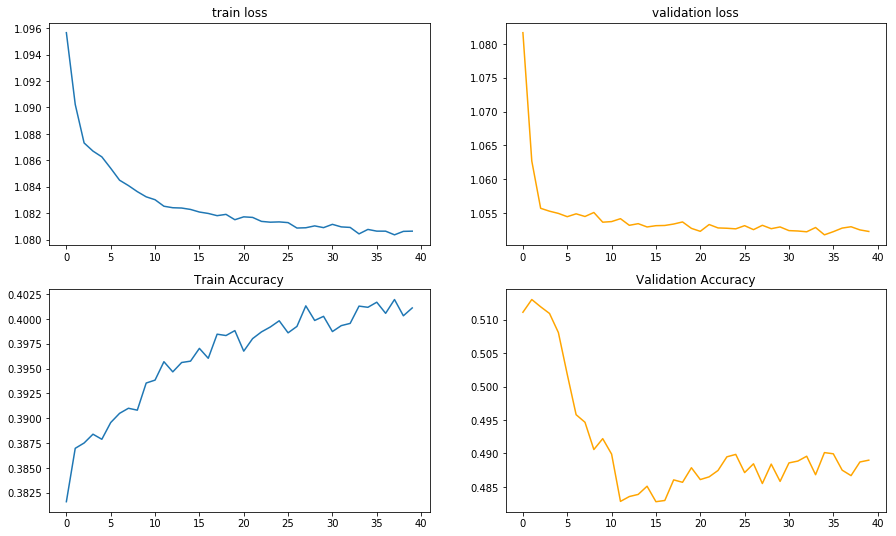

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [18]:
# summarize history for loss
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,9))

axes[0,0].set_title('train loss')
axes[0,0].plot(history.history['loss'])
axes[0,1].set_title('validation loss')
axes[0,1].plot(history.history['val_loss'], c='orange')


axes[1,0].plot(history.history['acc'])
axes[1,1].plot(history.history['val_acc'], c='orange')
axes[1,0].set_title('Train Accuracy')
axes[1,1].set_title('Validation Accuracy')

plt.show()

history.history.keys()


In [19]:
y_predicted_train = predict_point_by_point(model, X_train)
y_predicted_test = predict_point_by_point(model, X_test)

In [20]:
labels_true = np.argmax(Y_test,axis=1)
labels_predicted_test = np.argmax(y_predicted_test,axis=1)

'''
precision = metrics.precision_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)
recall = metrics.recall_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)
f1 = metrics.f1_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)

print('|-------------|       ' + '             '.join('{}'.format(k[1]) for k in enumerate([0,1,2])))
print('| precision   :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(precision)) + '      (catched percent of positives)')
print('| recall      :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(recall)) + '       (correct percent of positives predictions)')
print('| f1-score    :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(f1)))

print ('combined f1 score (macro):  ' + str(metrics.f1_score(y_true=labels_true, y_pred=labels_predicted_test, average='macro')))
print ('accuracy:  ' + str(metrics.accuracy_score(y_true=labels_true, y_pred=labels_predicted_test) ))
'''

"\nprecision = metrics.precision_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)\nrecall = metrics.recall_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)\nf1 = metrics.f1_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)\n\nprint('|-------------|       ' + '             '.join('{}'.format(k[1]) for k in enumerate([0,1,2])))\nprint('| precision   :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(precision)) + '      (catched percent of positives)')\nprint('| recall      :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(recall)) + '       (correct percent of positives predictions)')\nprint('| f1-score    :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(f1)))\n\nprint ('combined f1 score (macro):  ' + str(metrics.f1_score(y_true=labels_true, y_pred=labels_predicted_test, average='macro')))\nprint ('accuracy:  ' + str(metrics.accuracy_score(y_true=labels_true, y_pred=label

In [21]:
'''
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(17,14))

ax1.set_title("Train Labels")    
color_label = []
for p in Y_train:  
    if p[1] == 1:
        color = 'green'
    elif p[2] == 1:
        color = 'red' 
    else:
        color = 'black'
    color_label.append(color)
ax1.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=color_label, s=1)

ax2.set_title("Train Prediction")    
col2 = [] 
for p in y_predicted_train: 
    idx = np.argmax(p)
    if idx == 1:
        color = 'green'
    elif idx == 2:
        color = 'red' 
    else:
        color = 'black'
    col2.append(color)

ax2.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=col2, s=3)
plt.show()
'''


'\nfig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(17,14))\n\nax1.set_title("Train Labels")    \ncolor_label = []\nfor p in Y_train:  \n    if p[1] == 1:\n        color = \'green\'\n    elif p[2] == 1:\n        color = \'red\' \n    else:\n        color = \'black\'\n    color_label.append(color)\nax1.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=color_label, s=1)\n\nax2.set_title("Train Prediction")    \ncol2 = [] \nfor p in y_predicted_train: \n    idx = np.argmax(p)\n    if idx == 1:\n        color = \'green\'\n    elif idx == 2:\n        color = \'red\' \n    else:\n        color = \'black\'\n    col2.append(color)\n\nax2.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=col2, s=3)\nplt.show()\n'

In [22]:
y_predicted_test[100:120,:]



array([[0.4117759 , 0.29693076, 0.29129338],
       [0.4112442 , 0.2993908 , 0.289365  ],
       [0.41656968, 0.29658565, 0.28684464],
       [0.4124913 , 0.2924072 , 0.2951015 ],
       [0.41925782, 0.29089895, 0.28984314],
       [0.40855858, 0.28748977, 0.30395165],
       [0.42844155, 0.28588986, 0.28566864],
       [0.4308802 , 0.28167877, 0.28744113],
       [0.43637648, 0.27865583, 0.28496778],
       [0.4414045 , 0.2774309 , 0.28116465],
       [0.44285214, 0.27618974, 0.28095815],
       [0.43826684, 0.2743994 , 0.2873337 ],
       [0.44123054, 0.27290168, 0.28586778],
       [0.44417226, 0.272032  , 0.28379577],
       [0.44421193, 0.27015716, 0.28563097],
       [0.44465214, 0.27080017, 0.28454772],
       [0.44712263, 0.26991695, 0.28296047],
       [0.43647128, 0.26874804, 0.2947806 ],
       [0.4380955 , 0.2706726 , 0.29123193],
       [0.42348403, 0.26622006, 0.31029588]], dtype=float32)

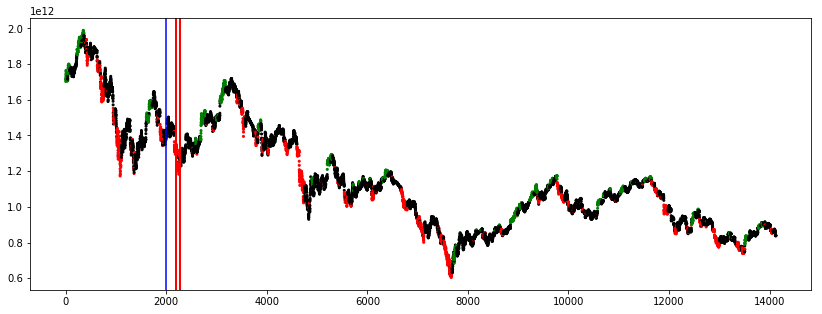

array([0.3697702 , 0.20163234, 0.42859742], dtype=float32)

In [28]:
point = 1990
start_of_train_position = point
position_on_plot = point + win_size
end_of_future_position = point + win_size + future


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14,5))
col3 = []
for p in y_predicted_test: 
    idx = np.argmax(p)
    if idx == 1:
        color = 'green'
    elif idx == 2:
        color = 'red' 
    else:
        color = 'black'
    col3.append(color)


ax1.scatter(range(y_tst_price.shape[0]),  y_tst_price, c=col3, s=4)

ax1.axvline(position_on_plot, color=col3[position_on_plot], lw=2)
ax1.axvline(end_of_future_position, color=col3[position_on_plot], lw=2)
ax1.axvline(start_of_train_position, color='blue')

plt.show()

y_predicted_test[position_on_plot,:]

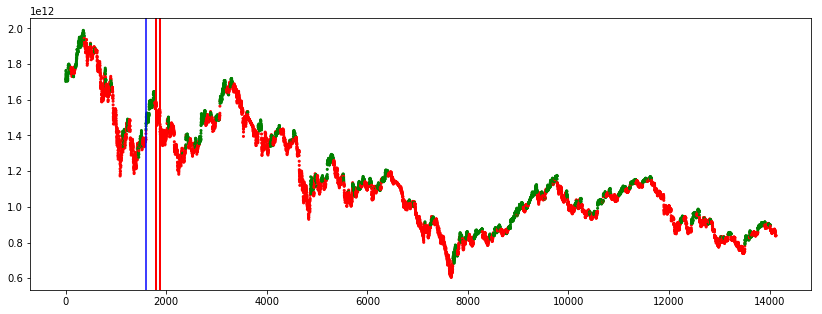

In [24]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14,5))
col3 = []
for p in y_predicted_test: 
    if p[1] > p[2]:
        color = 'green'
    else:
        color = 'red'

    col3.append(color)


ax1.scatter(range(y_tst_price.shape[0]),  y_tst_price, c=col3, s=4)

ax1.axvline(position_on_plot, color=col3[position_on_plot], lw=2)
ax1.axvline(end_of_future_position, color=col3[position_on_plot], lw=2)
ax1.axvline(start_of_train_position, color='blue')

plt.show()

In [25]:

# make win_size longer
# add data from several currencies 

# pile up more lstm layers (ascaded architecture )


In [ ]:

K.eval(model.optimizer.lr)
